In [3]:
import os
import pandas as pd

df = pd.read_csv('structured_data_11_17.csv')

# Define features and target
X = df.drop(['copy_number', 'log_copy_number', 'time_to_threshold'], axis=1)
y = df['log_copy_number']

In [21]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Function to fine-tune hyperparameters using GridSearchCV
def fine_tune_hyperparameters(X, y, param_grid):
    # Define XGBoost model
    xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

    # Perform Grid Search with 5-fold cross-validation
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=5,
        verbose=2,
        n_jobs=-1
    )

    # Fit the model to the entire dataset
    grid_search.fit(X, y)

    # Print and return the best parameters and best score
    print("Best Parameters:", grid_search.best_params_)
    print("Best CV Score (Negative MSE):", grid_search.best_score_)

    return grid_search.best_params_


# Function to run regression models and collect predictions
def run_regression_model(X, y, model):
    predictions_dict = defaultdict(list)  # Store predictions per actual value
    train_mse = []  # Track train MSE across iterations
    test_mse = []  # Track test MSE across iterations

    for trial in range(100):  # 100 iterations for robust evaluation
        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=trial)

        # Fit model
        model.fit(X_train, y_train)

        # Predict on train and test sets
        y_pred = model.predict(X_test)
        train_pred = model.predict(X_train)

        # Collect predictions
        for pred, actual in zip(y_pred, y_test):
            predictions_dict[actual].append(pred)

        # Calculate and store MSE
        train_mse.append(mean_squared_error(y_train, train_pred))
        test_mse.append(mean_squared_error(y_test, y_pred))

    # Convert predictions dictionary to DataFrame
    predictions_df = pd.DataFrame.from_dict(predictions_dict, orient='index').transpose()
    avg_train_mse = np.mean(train_mse)
    avg_test_mse = np.mean(test_mse)

    return avg_train_mse, avg_test_mse, predictions_df


# Function to plot predictions vs actual values with error bars
def plot_model_predictions(X, y, model):
    # Run the model and collect results
    avg_train_mse, avg_test_mse, predictions_df = run_regression_model(X, y, model)
    regression_model_name = model.__class__.__name__

    # Print average metrics
    print(f'Average Train MSE: {avg_train_mse}')
    print(f'Average Test MSE: {avg_test_mse}')

    # Plot errors
    plot_model_errors([predictions_df], [f'{regression_model_name} for 100 train-test splits'])


# Function to plot error bars and scatter plot
def plot_model_errors(predictions_dfs, model_names):
    plt.figure(figsize=(10, 10))

    # Loop through predictions DataFrames and model names
    for predictions_df, model_name in zip(predictions_dfs, model_names):
        means = []  # To store means of predictions
        stds = []  # To store standard deviations of predictions

        # Compute means and standard deviations for error bars
        for y in predictions_df.columns:
            vals = [val for val in predictions_df[y] if str(val) != "nan"]
            means.append(np.mean(vals))
            stds.append(np.std(vals))

        # Plot error bars
        plt.errorbar(predictions_df.columns, means, yerr=stds, fmt='o',
                     capsize=5, linestyle='None', label=model_name)

    # Add diagonal line for reference
    plt.plot([1, 6], [1, 6], color='red', linestyle='--')

    # Customize plot
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Predicted vs Actual log copy #')
    plt.legend()
    plt.show()

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.15, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1.5, 'subsample': 0.8}
Best CV Score (Negative MSE): -0.12640251161186025
Average Train MSE: 4.144217203976447e-07
Average Test MSE: 0.11402550181621969


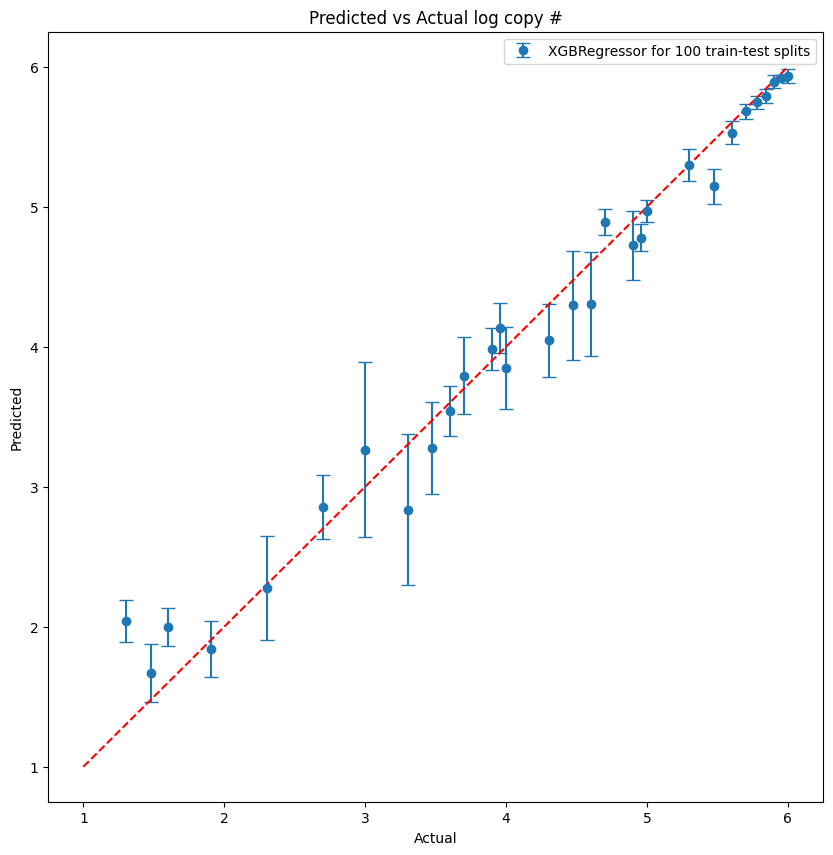

In [22]:
# Define hyperparameter grid for fine-tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 5, 6],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 1.5],
}

# Fine-tune hyperparameters
# Replace X and y with your dataset
best_params = fine_tune_hyperparameters(X, y, param_grid)

# Train final model with best parameters
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42, **best_params)

# Plot predictions and errors
plot_model_predictions(X, y, xgb_model)